<a href="https://colab.research.google.com/github/tommy-ngg/2023_Datathon/blob/main/2023_Datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
import plotly.express as px
from plotnine import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#import geopandas as gpd

In [ ]:
df = pd.read_csv('Investment_Data_Train.xlsx - train_data.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,MSN,StateCode,Year,Amount,State,CO2 Emissions (Mmt),TotalNumberofInvestments,TotalAmountofAssistance
0,BDFDB,AK,2015,21.0,Alaska,35.027804,16.0,3345612.0
1,BDPRP,AK,2015,4.0,Alaska,35.027804,16.0,3345612.0
2,BFFDB,AK,2015,21.0,Alaska,35.027804,16.0,3345612.0
3,BFPRP,AK,2015,4.0,Alaska,35.027804,16.0,3345612.0
4,CLPRB,AK,2015,17747.0,Alaska,35.027804,16.0,3345612.0


### Combining additional data

In [ ]:
msn_codes = df['MSN'].unique()
msn_codes

years_to_add = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]

#Gets MSN code data for given msn_codes and years_to_add
new_seds = pd.read_csv('Complete_SEDS.csv')
new_seds = new_seds[new_seds['MSN'].isin(msn_codes)]
new_seds = new_seds[new_seds['Year'].isin(years_to_add)]
new_seds = new_seds.reset_index().drop(['index','Data_Status'], axis=1)

new_seds.columns = ['MSN', 'StateCode', 'Year', 'Amount']
new_seds

#Collapses the new MSN data
grouped_seds = new_seds.groupby(['StateCode', 'Year'])['Amount']
seds_data = []
for key, item in grouped_seds:
  data = []
  data.extend(key)
  data.extend(list(item))
  seds_data.append(data)

new_cols = ['StateCode', 'Year']
new_cols.extend(msn_codes)

grouped_seds_df = pd.DataFrame(seds_data, columns=new_cols)
grouped_seds_df = grouped_seds_df[grouped_seds_df["StateCode"].str.contains("DC|US|X3|X5")==False]
grouped_seds_df

,StateCode,Year,BDFDB,BDPRP,BFFDB,BFPRP,CLPRB,CLPRK,CLPRP,COPRK,...,REPRB,SOTCB,TEPRB,TETCB,WDEXB,WDPRB,WDTCB,WSTCB,WWPRB,WYTCB
0,AK,2005,0.0,0.0,0.0,0.0,22682.0,15.600,1454.0,5.8,...,15866.0,0.0,2416187.0,797723.0,0.0,1093.0,1093.0,40.0,1133.0,6.0
1,AK,2006,0.0,0.0,0.0,0.0,22230.0,15.600,1425.0,5.8,...,13298.0,0.0,2101391.0,746457.0,0.0,997.0,997.0,69.0,1065.0,8.0
2,AK,2007,0.0,0.0,0.0,0.0,20654.0,15.600,1324.0,5.8,...,14037.0,0.0,2052850.0,723227.0,0.0,1076.0,1076.0,102.0,1177.0,10.0
3,AK,2008,0.0,0.0,0.0,0.0,23041.0,15.600,1477.0,5.8,...,12913.0,2.0,1933836.0,650500.0,0.0,1189.0,1189.0,44.0,1233.0,1.0
4,AK,2009,0.0,0.0,0.0,0.0,29016.0,15.600,1860.0,5.8,...,15685.0,3.0,1854325.0,639557.0,0.0,2472.0,2472.0,71.0,2543.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,WY,2010,0.0,0.0,1007.0,175.0,7658286.0,17.306,442522.0,5.8,...,44768.0,6.0,10528548.0,541026.0,0.0,1492.0,1492.0,0.0,1492.0,31676.0
516,WY,2011,0.0,0.0,1546.0,269.0,7591675.0,17.306,438673.0,5.8,...,60357.0,6.0,10343561.0,557822.0,0.0,1434.0,1434.0,2.0,1436.0,44809.0
517,WY,2012,0.0,0.0,1794.0,314.0,6973727.0,17.372,401442.0,5.8,...,53776.0,15.0,9603286.0,551037.0,0.0,1222.0,1222.0,2.0,1225.0,41576.0
518,WY,2013,0.0,0.0,1813.0,317.0,6760447.0,17.427,387924.0,5.8,...,53125.0,24.0,9232597.0,539997.0,0.0,1542.0,1542.0,2.0,1544.0,42298.0


In [ ]:
past_co2 = pd.read_csv('CO2_emissions.csv')

new_co2_states = []
new_co2_data = []

#Gets CO2 emmissions data for given years_to_add
new_co2 = pd.DataFrame(columns=(['State', 'Year', 'Data']))

for year in years_to_add:
  year = str(year)
  new_data = pd.DataFrame({'State': past_co2.State, 'Data': past_co2[year]})
  new_data['Year'] = year
  new_co2 = pd.concat([new_co2, new_data], axis=0)

new_co2 = new_co2.reset_index().drop('index', axis=1)
new_co2.columns = ['State', 'Year', 'CO2 Emissions (Mmt)']
new_co2

,State,Year,CO2 Emissions (Mmt)
0,Alabama,2005,143.5
1,Alaska,2005,47.5
2,Arizona,2005,97.3
3,Arkansas,2005,60.2
4,California,2005,389.6
...,...,...,...
505,Virginia,2014,107.4
506,Washington,2014,72.5
507,West Virginia,2014,99.9
508,Wisconsin,2014,101.2


In [ ]:
new_investments = pd.DataFrame()

#Combines multiple years of investment data into one dataframe

#For csv files with incorrect header
for year in [2005, 2006, 2010, 2011, 2014]:
  year = str(year)
  csvfile = year + "_investments.csv"
  new_invest_year = pd.read_csv(csvfile)
  new_invest_year = new_invest_year.drop(0, axis=0)
  new_invest_year = new_invest_year.drop(columns=list(new_invest_year.columns)[3:], axis=1)
  new_invest_year['Year'] = year
  new_investments = pd.concat([new_investments, new_invest_year], axis=0)

new_investments = new_investments.drop(columns=list(new_investments.columns)[4:])
new_investments.columns = ['State', 'TotalNumberofInvestments', 'TotalAmountofAssistance', 'Year']

#For csv files with previous header
for year in [2007, 2008, 2009, 2012, 2013]:
  year = str(year)
  csvfile = year + "_investments.csv"
  new_invest_year = pd.read_csv(csvfile)
  new_invest_year = new_invest_year.drop(columns=list(new_invest_year.columns)[3:], axis=1)
  new_invest_year['Year'] = year
  new_invest_year.columns = ['State', 'TotalNumberofInvestments', 'TotalAmountofAssistance', 'Year']
  new_investments = pd.concat([new_investments, new_invest_year], axis=0)

new_investments

,State,TotalNumberofInvestments,TotalAmountofAssistance,Year
1,Alaska,1,"$2,500,000",2005
2,California,6,"$849,422",2005
3,Georgia,1,"$118,150",2005
4,Hawaii,2,"$100,000",2005
5,Idaho,4,"$417,614",2005
...,...,...,...,...
49,Virginia,31,"$886,153",2013
50,Washington,53,"$1,466,329",2013
51,West Virginia,44,"$303,202",2013
52,Wisconsin,70,"$2,546,591",2013


In [ ]:
#Combines the above three dataframes

states_map = {"Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO",
    "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI","Idaho": "ID","Illinois": "IL","Indiana": "IN",
    "Iowa": "IA","Kansas": "KS","Kentucky": "KY","Louisiana": "LA","Maine": "ME","Maryland": "MD","Massachusetts": "MA","Michigan": "MI",
    "Minnesota": "MN","Mississippi": "MS","Missouri": "MO","Montana": "MT","Nebraska": "NE","Nevada": "NV","New Hampshire": "NH",
    "New Jersey": "NJ","New Mexico": "NM","New York": "NY","North Carolina": "NC","North Dakota": "ND","Ohio": "OH","Oklahoma": "OK",
    "Oregon": "OR","Pennsylvania": "PA","Rhode Island": "RI","South Carolina": "SC","South Dakota": "SD","Tennessee": "TN",
    "Texas": "TX","Utah": "UT","Vermont": "VT","Virginia": "VA","Washington": "WA","West Virginia": "WV","Wisconsin": "WI","Wyoming": "WY",
    "District of Columbia": "DC","American Samoa": "AS","Guam": "GU","Northern Mariana Islands": "MP","Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM","U.S. Virgin Islands": "VI",}

#Outer merges them on State and Year
combined = new_co2.merge(new_investments, how='outer', on=['State', 'Year'])

combined['StateCode'] = combined['State'].map(lambda x: states_map.get(x, x))
combined['Year'] = combined.Year.astype('int')
combined = combined.merge(grouped_seds_df, how='outer', on=['StateCode', 'Year'])

#Removes non-states
combined = combined[combined['State'].isin(new_co2.State.unique())]
combined = combined[combined['StateCode'].str.contains('DC')==False]

#Changes data types to match original data
combined['State'] = combined.State.astype('category')
combined['Year'] = combined.Year.astype('category')
combined['TotalAmountofAssistance'] = pd.to_numeric(combined['TotalAmountofAssistance'].str.replace('[^-.0-9]', ''))
combined['TotalNumberofInvestments'] = combined.TotalNumberofInvestments.astype('float')
combined = combined.drop('StateCode', axis=1)

combined

<ipython-input-125-002ee0e5f191>:27: FutureWarning: The default value of regex will change from True to False in a future version.


,State,Year,CO2 Emissions (Mmt),TotalNumberofInvestments,TotalAmountofAssistance,BDFDB,BDPRP,BFFDB,BFPRP,CLPRB,...,REPRB,SOTCB,TEPRB,TETCB,WDEXB,WDPRB,WDTCB,WSTCB,WWPRB,WYTCB
0,Alabama,2005,143.5,NaN,NaN,0.0,0.0,0.0,0.0,518423.0,...,279600.0,53.0,1501696.0,2065572.0,0.0,174727.0,174727.0,3306.0,178033.0,0.0
1,Alaska,2005,47.5,1.0,2500000.0,0.0,0.0,0.0,0.0,22682.0,...,15866.0,0.0,2416187.0,797723.0,0.0,1093.0,1093.0,40.0,1133.0,6.0
2,Arizona,2005,97.3,NaN,NaN,0.0,0.0,0.0,0.0,263426.0,...,78335.0,2575.0,611617.0,1443203.0,0.0,10734.0,10734.0,649.0,11383.0,0.0
3,Arkansas,2005,60.2,NaN,NaN,211.0,39.0,211.0,39.0,67.0,...,112661.0,90.0,484985.0,1116515.0,0.0,78375.0,78375.0,2815.0,81190.0,0.0
4,California,2005,389.6,6.0,849422.0,351.0,65.0,2496.0,427.0,0.0,...,741641.0,22264.0,2808671.0,8151775.0,0.0,108828.0,108828.0,36780.0,145608.0,42618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,Virginia,2014,107.4,44.0,1264174.0,310.0,57.0,5438.0,954.0,393225.0,...,135886.0,729.0,985083.0,2484858.0,0.0,98209.0,98209.0,20725.0,118934.0,0.0
506,Washington,2014,72.5,48.0,1947421.0,5961.0,1097.0,5961.0,1097.0,0.0,...,940937.0,471.0,1040270.0,2008907.0,0.0,99671.0,99671.0,8887.0,108558.0,69117.0
507,West Virginia,2014,99.9,102.0,701031.0,0.0,0.0,0.0,0.0,2858022.0,...,50019.0,85.0,4214048.0,781076.0,0.0,24144.0,24144.0,144.0,24288.0,13803.0
508,Wisconsin,2014,101.2,61.0,2223469.0,1515.0,279.0,76001.0,13314.0,0.0,...,216594.0,468.0,315402.0,1889496.0,0.0,91340.0,91340.0,9277.0,100617.0,15387.0


### Preprocessing data

In [ ]:
#Drops all non-states
df = df.dropna()
df = df[df["StateCode"].str.contains("DC|US|X3|X5")==False]
#df = df.drop(['StateCode', 'Unnamed: 0'], axis=1)
df = df.reset_index().drop(['index'], axis=1)

#Convert columns to categorical type
df['MSN'] = df.MSN.astype('category')
df['State'] = df.State.astype('category')
df['Year'] = df.Year.astype('category')

df

,MSN,StateCode,Year,Amount,State,CO2 Emissions (Mmt),TotalNumberofInvestments,TotalAmountofAssistance
0,BDFDB,AK,2015,21.0,Alaska,35.027804,16.0,3345612.0
1,BDPRP,AK,2015,4.0,Alaska,35.027804,16.0,3345612.0
2,BFFDB,AK,2015,21.0,Alaska,35.027804,16.0,3345612.0
3,BFPRP,AK,2015,4.0,Alaska,35.027804,16.0,3345612.0
4,CLPRB,AK,2015,17747.0,Alaska,35.027804,16.0,3345612.0
...,...,...,...,...,...,...,...,...
7245,WDPRB,WY,2019,4969.0,Wyoming,59.096649,32.0,570570.0
7246,WDTCB,WY,2019,4969.0,Wyoming,59.096649,32.0,570570.0
7247,WSTCB,WY,2019,0.0,Wyoming,59.096649,32.0,570570.0
7248,WWPRB,WY,2019,4969.0,Wyoming,59.096649,32.0,570570.0


In [ ]:
#Gets list of amounts for each code per state and year
grouped_df = df.groupby(['State', 'Year'])['Amount']
msn_data = []
for key, item in grouped_df:
  msn_data.append(list(item))

#Combines the flipped msn data with collapsed original data
msn_data_df = pd.DataFrame(msn_data, columns=msn_codes)

msn_df = df.copy(deep=True)
msn_df = msn_df.drop(['MSN', 'Amount', 'StateCode'], axis=1)
msn_df = msn_df.drop_duplicates().reset_index().drop(['index'], axis=1)
msn_df = msn_df.join(msn_data_df)
msn_df

,Year,State,CO2 Emissions (Mmt),TotalNumberofInvestments,TotalAmountofAssistance,BDFDB,BDPRP,BFFDB,BFPRP,CLPRB,...,REPRB,SOTCB,TEPRB,TETCB,WDEXB,WDPRB,WDTCB,WSTCB,WWPRB,WYTCB
0,2015,Alaska,35.027804,16.0,3345612.0,1933.0,356.0,1933.0,356.0,331420.0,...,258955.0,101.0,1267004.0,1917138.0,0.0,163313.0,163313.0,1565.0,164877.0,0.0
1,2015,Alabama,119.200889,164.0,1864412.0,1906.0,351.0,1906.0,351.0,247632.0,...,230734.0,431.0,1118407.0,1922727.0,0.0,162166.0,162166.0,1606.0,163772.0,0.0
2,2015,Arkansas,59.053365,477.0,13453887.0,1585.0,292.0,1585.0,292.0,326748.0,...,258549.0,1812.0,1230179.0,1904206.0,1137.0,168195.0,167058.0,1712.0,169907.0,0.0
3,2015,Arizona,94.978784,65.0,1724853.0,1652.0,304.0,1652.0,304.0,370533.0,...,279560.0,3425.0,1245875.0,1956413.0,4462.0,171215.0,166753.0,1680.0,172895.0,0.0
4,2015,California,351.408516,1023.0,30077512.0,1494.0,275.0,1494.0,275.0,350506.0,...,278142.0,3628.0,1250624.0,1926332.0,5308.0,169739.0,164431.0,1577.0,171316.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2019,Vermont,6.020391,27.0,1121855.0,0.0,0.0,1192.0,209.0,6538240.0,...,49887.0,27.0,9080777.0,507121.0,0.0,4904.0,4904.0,2.0,4905.0,35009.0
246,2019,Washington,84.169482,88.0,18389113.0,0.0,0.0,0.0,0.0,5169939.0,...,54565.0,33.0,7518440.0,504984.0,0.0,4357.0,4357.0,2.0,4358.0,40522.0
247,2019,Wisconsin,94.822424,103.0,2915140.0,0.0,0.0,0.0,0.0,5516757.0,...,55916.0,45.0,7794586.0,534840.0,0.0,5049.0,5049.0,0.0,5049.0,39806.0
248,2019,West Virginia,85.445996,44.0,790383.0,0.0,0.0,0.0,0.0,5315953.0,...,51483.0,67.0,7711992.0,557604.0,0.0,4934.0,4934.0,0.0,4934.0,36936.0


In [ ]:
#Combines the original data with the new data and drops NaN values
msn_df = pd.concat([msn_df, combined]).sort_values(by='Year').dropna().reset_index().drop('index', axis=1)
msn_df

,Year,State,CO2 Emissions (Mmt),TotalNumberofInvestments,TotalAmountofAssistance,BDFDB,BDPRP,BFFDB,BFPRP,CLPRB,...,REPRB,SOTCB,TEPRB,TETCB,WDEXB,WDPRB,WDTCB,WSTCB,WWPRB,WYTCB
0,2005,Nevada,50.200000,1.0,250000.0,6.0,1.0,6.0,1.0,0.0,...,34483.0,709.0,37081.0,704993.0,0.0,2799.0,2799.0,38.0,2837.0,0.0
1,2005,New York,211.500000,3.0,1080000.0,0.0,0.0,0.0,0.0,0.0,...,365545.0,853.0,866213.0,4153203.0,0.0,79535.0,79535.0,25701.0,105236.0,1030.0
2,2005,North Carolina,154.200000,1.0,2500.0,0.0,0.0,0.0,0.0,0.0,...,145276.0,116.0,562525.0,2702238.0,0.0,87729.0,87729.0,3074.0,90804.0,0.0
3,2005,North Dakota,53.000000,5.0,5104936.0,0.0,0.0,4399.0,744.0,392566.0,...,23400.0,2.0,690744.0,409142.0,0.0,582.0,582.0,2330.0,2912.0,2203.0
4,2005,Ohio,271.900000,3.0,592415.0,0.0,0.0,230.0,39.0,606427.0,...,54496.0,161.0,935376.0,4081429.0,0.0,45182.0,45182.0,2103.0,47285.0,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,2019,Maine,14.426405,41.0,1093090.0,0.0,0.0,0.0,0.0,0.0,...,38784.0,1044.0,38784.0,140546.0,0.0,23753.0,23753.0,307.0,24060.0,3032.0
712,2019,Michigan,159.239981,65.0,2360732.0,0.0,0.0,0.0,0.0,0.0,...,35637.0,1335.0,35637.0,135276.0,0.0,21418.0,21418.0,220.0,21638.0,2688.0
713,2019,Minnesota,92.089690,140.0,29572563.0,0.0,0.0,0.0,0.0,0.0,...,37792.0,2029.0,37792.0,134076.0,0.0,20957.0,20957.0,167.0,21124.0,2814.0
714,2019,Iowa,77.296215,120.0,3041432.0,22916.0,4218.0,71381.0,12718.0,515707.0,...,709194.0,10946.0,17008753.0,12986076.0,0.0,53208.0,53208.0,27667.0,80874.0,531124.0


In [ ]:
#Gets numeric data
num_feats = ['CO2 Emissions (Mmt)', 'TotalNumberofInvestments', 'TotalAmountofAssistance']
num_feats.extend(msn_codes)

df_num = msn_df[num_feats]

#Scaling numerical data
scaler = MinMaxScaler()
taoa = df_num.pop('TotalAmountofAssistance')
df_scaled = scaler.fit_transform(df_num.to_numpy())
num_feats.pop(2)
df_scaled = pd.DataFrame(df_scaled, columns = num_feats)

#Categorical features to include:
cat_feats = ['State']
#One-hot encodes and joins the cat feats
df_cat = msn_df[cat_feats].join(df_scaled).reset_index().drop('index', axis=1)
df_pp = pd.concat([df_cat, pd.get_dummies(msn_df[cat_feats])], axis=1)
df_pp = df_pp.drop(columns=cat_feats)

df_pp['TotalAmountofAssistance'] = taoa
df_pp

,CO2 Emissions (Mmt),TotalNumberofInvestments,BDFDB,BDPRP,BFFDB,BFPRP,CLPRB,CLPRK,CLPRP,COPRK,...,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,TotalAmountofAssistance
0,0.065814,0.000000,0.000127,0.000115,0.000009,0.000009,0.000000,0.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0,250000.0
1,0.303303,0.001957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0,1080000.0
2,0.218937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,2500.0
3,0.069936,0.003914,0.000000,0.000000,0.006861,0.006600,0.048540,0.489139,0.064057,1.000000,...,0,0,0,0,0,0,0,0,0,5104936.0
4,0.392232,0.001957,0.000000,0.000000,0.000359,0.000346,0.074984,0.915721,0.052856,1.000000,...,0,0,0,0,0,0,0,0,0,592415.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0.013143,0.039139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1093090.0
712,0.226358,0.062622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,2360732.0
713,0.127490,0.136008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,29572563.0
714,0.105709,0.116438,0.485354,0.485386,0.111333,0.112823,0.063766,0.493543,0.083399,0.986552,...,0,0,0,0,0,0,0,0,0,3041432.0


### Training and Testing

In [ ]:
#Train-validation split
X = df_pp.copy(deep=True)
y = X.pop('TotalAmountofAssistance')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

#Baseline linear regression
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(mean_squared_error(y_test, y_pred, squared=False))

#Check feature weights
lr_coefs = pd.DataFrame({'Feature': X_train.columns, 'LR_Coefficient': lin_reg.coef_.transpose().flatten()})
lr_coefs = lr_coefs.sort_values('LR_Coefficient', ascending=False)
lr_coefs

28307728.406323977


,Feature,LR_Coefficient
73,State_Texas,4.785322e+19
63,State_North Carolina,4.785322e+19
47,State_Kentucky,4.785322e+19
48,State_Louisiana,4.785322e+19
35,State_California,4.785322e+19
...,...,...
11,ENPRP,-5.324481e+11
27,WDTCB,-7.580484e+11
23,TEPRB,-2.916098e+12
21,REPRB,-3.067849e+12


In [ ]:
#Random Forest

rfr_df = pd.DataFrame(np.arange(1,11,1), columns=['depth'])

#Iterate through each depth from 1 to 10 and use Random Forest Regression with it
for depth in range(1, 11):
  rfr = RandomForestRegressor(max_depth=depth, random_state=0)
  rfr.fit(X_train, y_train)
  #Predict the training data
  train_pred = rfr.predict(X_train)
  train = pd.DataFrame(train_pred, columns=['pred'])
  #Predict the testing data
  valid_pred = rfr.predict(X_test)
  valid = pd.DataFrame(valid_pred, columns=['pred'])
  #Find the RMSE and adds it to the DF
  train_rmse = mean_squared_error(y_train, train.pred, squared=False)
  valid_rmse = mean_squared_error(y_test, valid.pred, squared=False)
  rfr_df.loc[depth-1, 'train_rmse'] = train_rmse
  rfr_df.loc[depth-1, 'valid_rmse'] = valid_rmse

rfr = RandomForestRegressor(max_depth=6, random_state=0)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print(mean_squared_error(y_test, y_pred, squared=False))

23942554.545321345


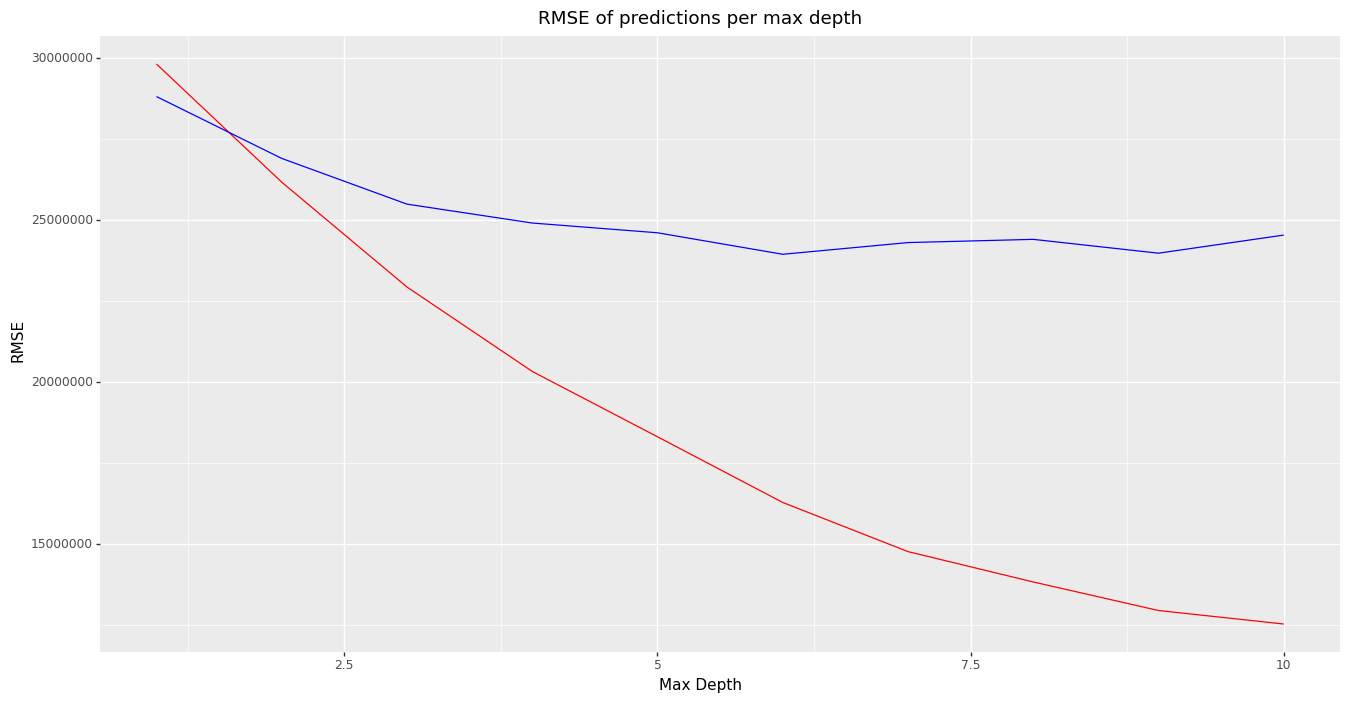

<ggplot: (8772374956590)>

In [ ]:
(ggplot(rfr_df, aes(x='depth'))
+ theme(figure_size=(16, 8))
+ geom_line(aes(y='train_rmse'), color='red')
+ geom_line(aes(y='valid_rmse'), color='blue')
+ labs(x = "Max Depth", y = "RMSE", title = 'RMSE of predictions per max depth')
)

In [ ]:
#2020 Testing

testing_data = pd.read_csv('Investment_Data_2020_withResponseVariable.csv')
testing_data.pop('Unnamed: 0')

testing_data = testing_data[testing_data["StateCode"].str.contains("DC|US|X3|X5")==False]
testing_data = testing_data.reset_index().drop('index', axis=1)

#Preprocessing

#Gets list of amounts for each code per state and year
grouped_testing = testing_data.groupby(['State', 'Year'])['Amount']
msn_data = []
for key, item in grouped_testing:
  msn_data.append(list(item))

#Combines the flipped msn data with collapsed original data
msn_data_test = pd.DataFrame(msn_data, columns=msn_codes)

msn_test = testing_data.copy(deep=True)
msn_test = msn_test.drop(['MSN', 'Amount', 'StateCode'], axis=1)
msn_test = msn_test.drop_duplicates().reset_index().drop(['index'], axis=1)
msn_test = msn_test.join(msn_data_df)

y_test = msn_test.pop('TotalAmountofAssistance')

num_feats = ['CO2 Emissions (Mmt)', 'TotalNumberofInvestments']
num_feats.extend(msn_codes)

test_num = msn_test[num_feats]

#Scaling numerical data (same scaler as before)
test_scaled = scaler.transform(test_num.to_numpy())
test_scaled = pd.DataFrame(test_scaled, columns = num_feats)

#Categorical features to include:
cat_feats = ['State']
#One-hot encodes and joins the cat feats
test_cat = msn_test[cat_feats].join(test_scaled).reset_index().drop('index', axis=1)
test_pp = pd.concat([test_cat, pd.get_dummies(msn_test[cat_feats])], axis=1)
test_pp = test_pp.drop(columns=cat_feats)

test_pp

,CO2 Emissions (Mmt),TotalNumberofInvestments,BDFDB,BDPRP,BFFDB,BFPRP,CLPRB,CLPRK,CLPRP,COPRK,...,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
0,0.044859,0.035225,0.040940,0.040967,0.003015,0.003158,0.040980,0.937668,0.028212,0.985690,...,0,0,0,0,0,0,0,0,0,0
1,0.136646,0.045010,0.040369,0.040391,0.002973,0.003114,0.030619,0.958495,0.020620,0.986552,...,0,0,0,0,0,0,0,0,0,0
2,0.072502,0.169276,0.033570,0.033602,0.002472,0.002590,0.040402,0.948305,0.027502,0.986724,...,0,0,0,0,0,0,0,0,0,0
3,0.109891,0.022505,0.034989,0.034983,0.002577,0.002697,0.045816,0.935540,0.031612,0.983793,...,0,0,0,0,0,0,0,0,0,0
4,0.438621,0.431507,0.031642,0.031646,0.002330,0.002440,0.043340,0.926247,0.030202,0.982414,...,0,0,0,0,0,0,0,0,0,0
5,0.109533,0.044031,0.000445,0.000460,0.000033,0.000035,0.002194,0.562593,0.002517,0.985690,...,0,0,0,0,0,0,0,0,0,0
6,0.041621,0.011742,0.000572,0.000575,0.000042,0.000044,0.001724,0.558264,0.001993,0.986552,...,0,0,0,0,0,0,0,0,0,0
7,0.010264,0.027397,0.000614,0.000575,0.000045,0.000044,0.001776,0.559047,0.002051,0.986724,...,0,0,0,0,0,0,0,0,0,0
8,0.297614,0.023483,0.000318,0.000345,0.000023,0.000027,0.001700,0.569312,0.001929,0.983793,...,0,0,0,0,0,0,0,0,0,0
9,0.163565,0.146771,0.000000,0.000000,0.000000,0.000000,0.001838,0.569274,0.002085,0.982414,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
rfr_test = RandomForestRegressor(max_depth=8, random_state=0)
rfr_test.fit(X, y)
test_pred = rfr_test.predict(test_pp)
print(mean_squared_error(y_test, test_pred, squared=False))

27413322.131431896


In [ ]:
results = pd.concat([test_pp, pd.DataFrame(test_pred, columns=['TotalAmountofAssistance'])], axis=1)
results = results.sort_values(by='TotalAmountofAssistance', ascending=False)
results

,CO2 Emissions (Mmt),TotalNumberofInvestments,BDFDB,BDPRP,BFFDB,BFPRP,CLPRB,CLPRK,CLPRP,COPRK,...,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,TotalAmountofAssistance
26,0.148756,0.082192,0.000000,0.000000,0.030353,0.030277,0.033499,0.800388,0.027016,0.986552,...,0,0,0,0,0,0,0,0,0,1.099829e+08
16,0.141913,0.086106,0.113883,0.113924,0.008387,0.008782,0.000120,0.735481,0.000105,0.986552,...,0,0,0,0,0,0,0,0,0,7.095230e+07
37,0.276417,0.047945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,2.149853e+07
45,-0.000118,0.021526,0.026305,0.026352,0.022714,0.022728,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,2.117197e+07
4,0.438621,0.431507,0.031642,0.031646,0.002330,0.002440,0.043340,0.926247,0.030202,0.982414,...,0,0,0,0,0,0,0,0,0,2.064093e+07
39,0.085395,0.083170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1.674001e+07
22,0.107308,0.163405,0.115133,0.115190,0.053404,0.053688,0.000000,0.000000,0.000000,0.986724,...,0,0,0,0,0,0,0,0,0,1.618237e+07
23,0.151949,0.127202,0.126019,0.126007,0.055315,0.055578,0.000000,0.000000,0.000000,0.983793,...,0,0,0,0,0,0,0,0,0,1.244657e+07
11,0.088563,0.151663,0.001207,0.001151,0.009676,0.009661,0.014427,0.803076,0.011596,0.986552,...,0,0,0,0,0,0,0,0,0,1.244650e+07
42,0.910589,0.057730,0.018109,0.018067,0.001334,0.001393,0.000000,0.000000,0.000000,0.986724,...,0,1,0,0,0,0,0,0,0,1.218607e+07


Top 5 States:

North Carolina

Kentucky

Pennsylvania

Vermont

California

### Visualizations

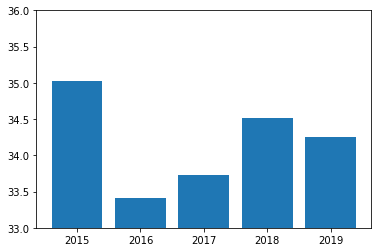

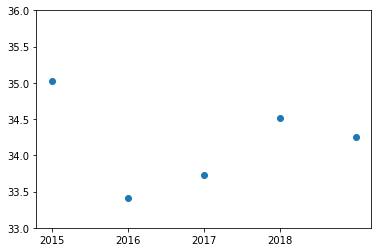

In [ ]:
#Sample Graph Showing CO2 emissions for Alaska over 5 years
Alaska_df = df[(df['State']=='Alaska') & (df['MSN']=='BDFDB')]
Alaska_df

plt.figure(1)
plt.bar(Alaska_df['Year'], Alaska_df['CO2 Emissions (Mmt)'])
low = min(Alaska_df['CO2 Emissions (Mmt)'])
high = max(Alaska_df['CO2 Emissions (Mmt)'])
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.show()

plt.figure(2)
plt.scatter(Alaska_df['Year'], Alaska_df['CO2 Emissions (Mmt)'])
plt.xticks(range(min(Alaska_df['Year']), max(Alaska_df['Year'])))
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.show()

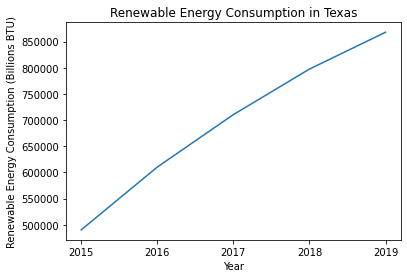

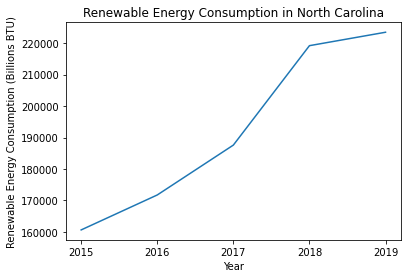

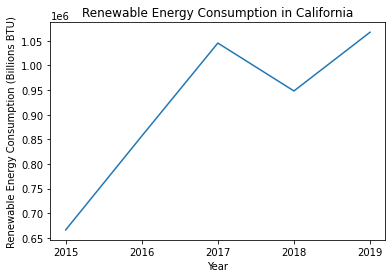

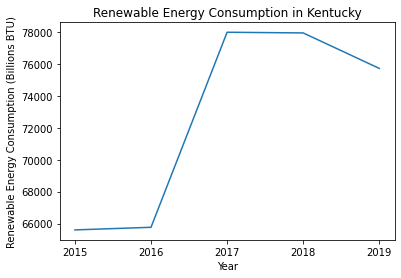

In [ ]:
#GETCB = Geothermal Consumption
#HYTCB = Hydropower consumption
#SOTCB = Solar Consumption
#WYTCB = Wind Consumption
#WDTCB = Wood Consumption

TX_df = df[(df['State']=='Texas')]
TX_df

TX_Renew=TX_df[(TX_df['MSN'] == 'GETCB')|(TX_df['MSN'] == 'HYTCB')|(TX_df['MSN'] == 'SOTCB')|(TX_df['MSN'] == 'WYTCB')|(TX_df['MSN'] == 'WDTCB')]
TX_Renew[TX_Renew['Year']==2015]['Amount'].sum()


plt.figure(1)
plt.plot([2015,2016,2017,2018,2019], [TX_Renew[TX_Renew['Year']==2015]['Amount'].sum(),TX_Renew[TX_Renew['Year']==2016]['Amount'].sum(),TX_Renew[TX_Renew['Year']==2017]['Amount'].sum(),TX_Renew[TX_Renew['Year']==2018]['Amount'].sum(),TX_Renew[TX_Renew['Year']==2019]['Amount'].sum()])
plt.xticks([2015,2016,2017,2018,2019])
plt.xlabel('Year')
plt.ylabel('Renewable Energy Consumption (Billions BTU)')
plt.title('Renewable Energy Consumption in Texas')
plt.show()

NC_df = df[(df['State']=='North Carolina')]
NC_df

NC_Renew=NC_df[(NC_df['MSN'] == 'GETCB')|(NC_df['MSN'] == 'HYTCB')|(NC_df['MSN'] == 'SOTCB')|(NC_df['MSN'] == 'WYTCB')|(NC_df['MSN'] == 'WDTCB')]
NC_Renew[NC_Renew['Year']==2015]['Amount'].sum()


plt.figure(2)
plt.plot([2015,2016,2017,2018,2019], [NC_Renew[NC_Renew['Year']==2015]['Amount'].sum(),NC_Renew[NC_Renew['Year']==2016]['Amount'].sum(),NC_Renew[NC_Renew['Year']==2017]['Amount'].sum(),NC_Renew[NC_Renew['Year']==2018]['Amount'].sum(),NC_Renew[NC_Renew['Year']==2019]['Amount'].sum()])
plt.xticks([2015,2016,2017,2018,2019])
plt.xlabel('Year')
plt.ylabel('Renewable Energy Consumption (Billions BTU)')
plt.title('Renewable Energy Consumption in North Carolina')
plt.show()

CA_df = df[(df['State']=='California')]

CA_Renew=CA_df[(CA_df['MSN'] == 'GETCB')|(CA_df['MSN'] == 'HYTCB')|(CA_df['MSN'] == 'SOTCB')|(CA_df['MSN'] == 'WYTCB')|(CA_df['MSN'] == 'WDTCB')]
CA_Renew[CA_Renew['Year']==2015]['Amount'].sum()


plt.figure(3)
plt.plot([2015,2016,2017,2018,2019], [CA_Renew[CA_Renew['Year']==2015]['Amount'].sum(),CA_Renew[CA_Renew['Year']==2016]['Amount'].sum(),CA_Renew[CA_Renew['Year']==2017]['Amount'].sum(),CA_Renew[CA_Renew['Year']==2018]['Amount'].sum(),CA_Renew[CA_Renew['Year']==2019]['Amount'].sum()])
plt.xticks([2015,2016,2017,2018,2019])
plt.xlabel('Year')
plt.ylabel('Renewable Energy Consumption (Billions BTU)')
plt.title('Renewable Energy Consumption in California')
plt.show()

KY_df = df[(df['State']=='Kentucky')]

KY_Renew=KY_df[(KY_df['MSN'] == 'GETCB')|(KY_df['MSN'] == 'HYTCB')|(KY_df['MSN'] == 'SOTCB')|(KY_df['MSN'] == 'WYTCB')|(KY_df['MSN'] == 'WDTCB')]
KY_Renew[KY_Renew['Year']==2015]['Amount'].sum()

plt.figure(4)
plt.plot([2015,2016,2017,2018,2019], [KY_Renew[KY_Renew['Year']==2015]['Amount'].sum(),KY_Renew[KY_Renew['Year']==2016]['Amount'].sum(),KY_Renew[KY_Renew['Year']==2017]['Amount'].sum(),KY_Renew[KY_Renew['Year']==2018]['Amount'].sum(),KY_Renew[KY_Renew['Year']==2019]['Amount'].sum()])
plt.xticks([2015,2016,2017,2018,2019])
plt.xlabel('Year')
plt.ylabel('Renewable Energy Consumption (Billions BTU)')
plt.title('Renewable Energy Consumption in Kentucky')
plt.show()


In [ ]:
Renewable_df

,MSN,StateCode,Year,Amount,State,CO2 Emissions (Mmt),TotalNumberofInvestments,TotalAmountofAssistance
10,GETCB,AK,2015,186.0,Alaska,35.027804,16.0,3345612.0
11,HYTCB,AK,2015,14621.0,Alaska,35.027804,16.0,3345612.0
20,SOTCB,AK,2015,3.0,Alaska,35.027804,16.0,3345612.0
25,WDTCB,AK,2015,6865.0,Alaska,35.027804,16.0,3345612.0
28,WYTCB,AK,2015,1488.0,Alaska,35.027804,16.0,3345612.0
...,...,...,...,...,...,...,...,...
7231,GETCB,WY,2019,663.0,Wyoming,59.096649,32.0,570570.0
7232,HYTCB,WY,2019,8838.0,Wyoming,59.096649,32.0,570570.0
7241,SOTCB,WY,2019,1688.0,Wyoming,59.096649,32.0,570570.0
7246,WDTCB,WY,2019,4969.0,Wyoming,59.096649,32.0,570570.0


In [ ]:
Renewable_df.head()

Renewable2015 = np.array(pd.DataFrame(Renewable_df[Renewable_df['Year'] == 2015].groupby(['State'])['Amount'].sum()))
Renewable2016 = np.array(pd.DataFrame(Renewable_df[Renewable_df['Year'] == 2016].groupby(['State'])['Amount'].sum()))
Renewable2017 = np.array(pd.DataFrame(Renewable_df[Renewable_df['Year'] == 2017].groupby(['State'])['Amount'].sum()))
Renewable2018 = np.array(pd.DataFrame(Renewable_df[Renewable_df['Year'] == 2018].groupby(['State'])['Amount'].sum()))
Renewable2019 = np.array(pd.DataFrame(Renewable_df[Renewable_df['Year'] == 2019].groupby(['State'])['Amount'].sum()))

In [ ]:
#Data for US State Populations

Pop2015_df = pd.read_csv('2015Pop.csv')
Pop2016_df = pd.read_csv('2016Pop.csv')
Pop2017_df = pd.read_csv('2017Pop.csv')
Pop2018_df = pd.read_csv('2018Pop.csv')
Pop2019_df = pd.read_csv('2019Pop.csv')

Pop2015_df = Pop2015_df[['NAME', 'POPESTIMATE2015']]
Pop2016_df = Pop2016_df[['NAME', 'POPESTIMATE2016']]
Pop2017_df = Pop2017_df[['NAME', 'POPESTIMATE2017']]
Pop2018_df = Pop2018_df[['NAME', 'POPESTIMATE2018']]
Pop2019_df = Pop2019_df[['NAME', 'POPESTIMATE2019']]

Pop_df = pd.DataFrame([Pop2015_df['NAME'], Pop2015_df['POPESTIMATE2015'], Pop2016_df['POPESTIMATE2016'], Pop2017_df['POPESTIMATE2017'], Pop2018_df['POPESTIMATE2018'], Pop2019_df['POPESTIMATE2019']])
Pop_df = Pop_df.transpose()

Pop_df = Pop_df[Pop_df['NAME'].str.contains('United States|District of Columbia|Puerto Rico')==False] 

Pop2015 = np.array(Pop_df['POPESTIMATE2015'])
Pop2016 = np.array(Pop_df['POPESTIMATE2016'])
Pop2017 = np.array(Pop_df['POPESTIMATE2017'])
Pop2018 = np.array(Pop_df['POPESTIMATE2018'])
Pop2019 = np.array(Pop_df['POPESTIMATE2019'])

In [ ]:
RenewCapita2015 = np.divide(Renewable2015, Pop2015)
RenewCapita2016 = np.divide(Renewable2015, Pop2016)
RenewCapita2017 = np.divide(Renewable2015, Pop2017)
RenewCapita2018 = np.divide(Renewable2015, Pop2018)
RenewCapita2019 = np.divide(Renewable2015, Pop2019)

RenewCapitaTotal_df = pd.DataFrame(Renewable_df[Renewable_df['Year'] == 2015].groupby(['State'])['Amount'].sum())
RenewCapitaTotal_df['Amount'] = RenewCapita2015 + RenewCapita2016 + RenewCapita2017 + RenewCapita2018 + RenewCapita2019

RenewCapitaTotal_df

RenewCapitaTotal_df.sort_values(by = ['Amount'])

,Amount
State,
Rhode Island,0.00269
Delaware,0.002821
Hawaii,0.017828
Connecticut,0.021992
Utah,0.023119
Alaska,0.023744
New Jersey,0.028895
West Virginia,0.038747
New Mexico,0.03921


In [ ]:
#pd.DataFrame(df['StateCode'].drop_duplicates()).reset_index()
df['StateCode'].drop_duplicates().reset_index().drop('index', axis=1)

,StateCode
0,AK
1,AL
2,AR
3,AZ
4,CA
5,CO
6,CT
7,DE
8,FL
9,GA


In [ ]:
#RenewCapita_df = pd.DataFrame(Renewable_df['State']).drop_duplicates()

RenewCapita_df = Pop_df
RenewCapita_df.reset_index(0)

RenewCapita_df['POPESTIMATE2015'] = RenewCapita2015
RenewCapita_df['POPESTIMATE2016'] = RenewCapita2016
RenewCapita_df['POPESTIMATE2017'] = RenewCapita2017
RenewCapita_df['POPESTIMATE2018'] = RenewCapita2018
RenewCapita_df['POPESTIMATE2019'] = RenewCapita2019

RenewCapita_df.rename(columns = {'NAME': 'State', 'POPESTIMATE2015':'Consumption/Capita 2015', 'POPESTIMATE2016':'Consumption/Capita 2016', 'POPESTIMATE2017':'Consumption/Capita 2017', 'POPESTIMATE2018':'Consumption/Capita 2018', 'POPESTIMATE2019':'Consumption/Capita 2019'}, inplace = True)


RenewCapita_df['State'] = df['StateCode'].drop_duplicates().reset_index().drop('index', axis=1)

RenewCapita_df

,State,Consumption/Capita 2015,Consumption/Capita 2016,Consumption/Capita 2017,Consumption/Capita 2018,Consumption/Capita 2019
1,AL,0.052574,0.052528,0.052404,0.052263,0.0521
2,AR,0.004767,0.004763,0.004752,0.004739,0.004724
3,AZ,0.025045,0.025023,0.024964,0.024897,0.024819
4,CA,0.022558,0.022538,0.022485,0.022425,0.022355
5,CO,0.13711,0.136989,0.136667,0.1363,0.135874
6,CT,0.021732,0.021712,0.021661,0.021603,0.021536
7,DE,0.004415,0.004411,0.004401,0.004389,0.004375
8,FL,0.000566,0.000566,0.000565,0.000563,0.000561
10,HI,0.031709,0.031681,0.031607,0.031522,0.031423
11,IA,0.04662,0.046579,0.04647,0.046345,0.0462


In [ ]:
TX_Renew = RenewCapita_df[RenewCapita_df['State'] == 'TX']
NC_Renew = RenewCapita_df[RenewCapita_df['State'] == 'NC']
WA_Renew = RenewCapita_df[RenewCapita_df['State'] == 'WA']

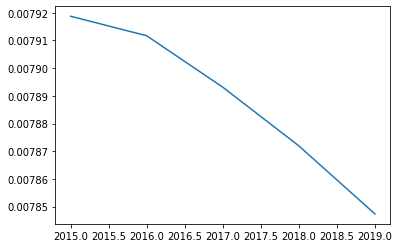

In [ ]:
plt.figure(1)
plt.plot([2015, 2016, 2017, 2018, 2019], [WA_Renew['Consumption/Capita 2015'],WA_Renew['Consumption/Capita 2016'],WA_Renew['Consumption/Capita 2017'],WA_Renew['Consumption/Capita 2018'],WA_Renew['Consumption/Capita 2019']])
#low = min(Alaska_df['CO2 Emissions (Mmt)'])
#high = max(Alaska_df['CO2 Emissions (Mmt)'])
#plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.show()

In [ ]:
Renewable_Consumption[Renewable_Consumption['State']=='Texas']

KeyError: ignored

In [ ]:
fig = px.choropleth(RenewCapita_df,
                    locations='State', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Consumption/Capita 2015',
                    color_continuous_scale= "blues" )
fig.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
Total_Sorted_Renew_Consum = pd.DataFrame(Renewable_Consumption.groupby(['State'])['Amount'].sum()).sort_values('Amount')
Total_Sorted_Renew_Consum



#Renewable_Consum1 = Renewable_Consumption[Renewable_Consumption['State'] == 'Delaware']

#plt.figure(1)
#plt.plot(Renewable_Consumption['Year'], )

#plt.show()

In [ ]:
df
df['Year']